In [43]:
# Importing data that has been downloaded from drivendata.org, consisting of blood donor information.
# Can we predict if a past donor will donate in the coming month? As a proxy for this, we will be using
# information prior to March 2007 to predict if the donor donated in March 2007. Our performance metric will
# be log-loss, which requires the predicted probability of donation in March 2007 for a given donor.
# Log-loss heaviliy penalizes high probability misclassification, as opposed to accuracy, which simply
# looks at the (unweighted) proportion of correct classifications.
# We begin with some exploratory data analysis.

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

print(os.getcwd())

df=pd.read_csv('python_files/Competition/blood/training_data.csv',index_col=0)
df.head()

/home/cooler/Dropbox/Jupyter


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
619,2,50,12500,98,1
664,0,13,3250,28,1
441,1,16,4000,35,1
160,2,20,5000,45,1
358,1,24,6000,77,0


In [44]:
# No null or missing values. The dataset is already very clean.

df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 576 entries, 619 to 74
Data columns (total 5 columns):
Months since Last Donation     576 non-null int64
Number of Donations            576 non-null int64
Total Volume Donated (c.c.)    576 non-null int64
Months since First Donation    576 non-null int64
Made Donation in March 2007    576 non-null int64
dtypes: int64(5)
memory usage: 27.0 KB


,Months since Last Donation,Number of Donations,Total Volume Donated (c.c.),Months since First Donation,Made Donation in March 2007
count,576.000000,576.000000,576.000000,576.000000,576.000000
mean,9.439236,5.427083,1356.770833,34.050347,0.239583
std,8.175454,5.740010,1435.002556,24.227672,0.427200
min,0.000000,1.000000,250.000000,2.000000,0.000000
25%,2.000000,2.000000,500.000000,16.000000,0.000000
50%,7.000000,4.000000,1000.000000,28.000000,0.000000
75%,14.000000,7.000000,1750.000000,49.250000,0.000000
max,74.000000,50.000000,12500.000000,98.000000,1.000000


In [45]:
# The mean and median values match up reasonably well.

df.median()

Months since Last Donation        7.0
Number of Donations               4.0
Total Volume Donated (c.c.)    1000.0
Months since First Donation      28.0
Made Donation in March 2007       0.0
dtype: float64

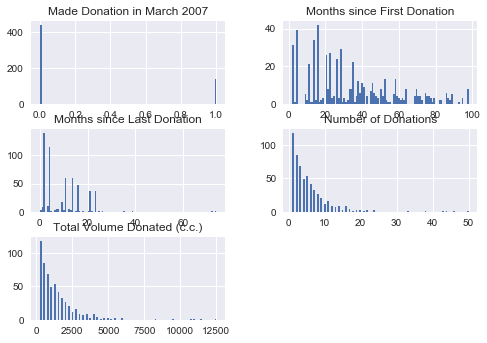

In [46]:
# Histogram indicates that the classification category, 'Made Donation in march 2007', has some imbalance, but
# it is not too severe.
# Additionally, some features may benefit from a log transform, given their current distribution.

import seaborn as sns
sns.set()
#df.hist(bins=int(np.sqrt(576)))
df.hist(bins=100)
plt.show()


In [47]:
# The features 'Total Volume Donated (c.c.)' and 'Number of Donations' appear to be a multiple of each other.
# In particular, everyone donates 250 c.c. of blood per donation. May need to remove one of these features.

amt_per_visit=df['Total Volume Donated (c.c.)'].div(df['Number of Donations'])
amt_per_visit.describe()

count    576.0
mean     250.0
std        0.0
min      250.0
25%      250.0
50%      250.0
75%      250.0
max      250.0
dtype: float64

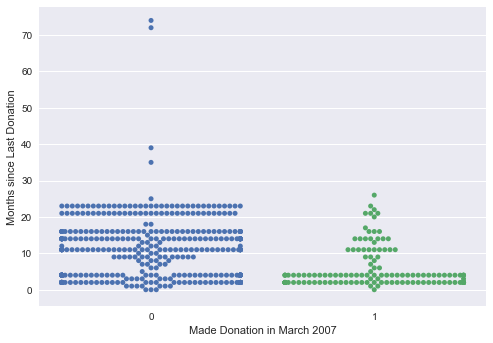

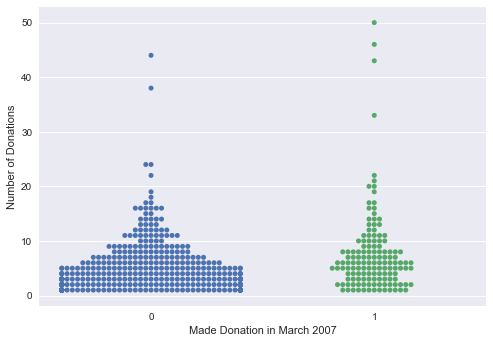

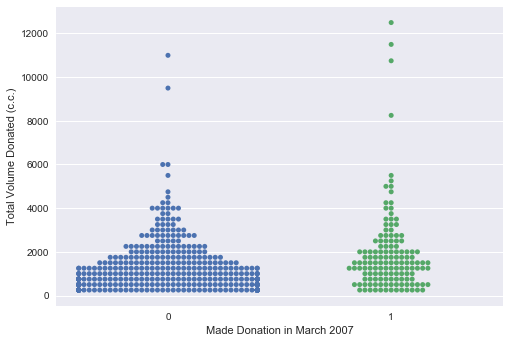

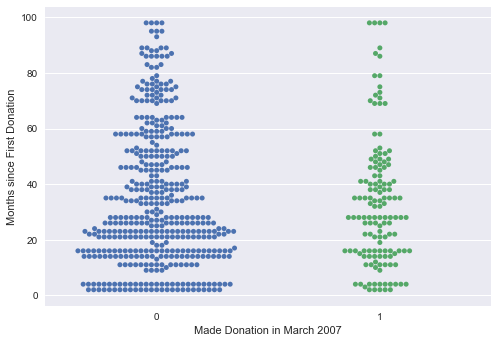

In [48]:
# Swarm plot of features colored by whether there was a donation in March 2007.
# Months since last donation does seem to have some decent correlation with the target class.

sns.swarmplot(x='Made Donation in March 2007',y='Months since Last Donation',data=df)
plt.show()
sns.swarmplot(x='Made Donation in March 2007',y='Number of Donations',data=df)
plt.show()
sns.swarmplot(x='Made Donation in March 2007',y='Total Volume Donated (c.c.)',data=df)
plt.show()
sns.swarmplot(x='Made Donation in March 2007',y='Months since First Donation',data=df)
plt.show()

In [49]:
# Correlations are present, but not particularly strong.
# Months since last donation does have the strongest correlation, as suspected.

ro=df.corr()
print(ro.values)

print(ro['Made Donation in March 2007'])

[[ 1.         -0.15973135 -0.15973135  0.18689945 -0.26123371]
 [-0.15973135  1.          1.          0.62211596  0.22061534]
 [-0.15973135  1.          1.          0.62211596  0.22061534]
 [ 0.18689945  0.62211596  0.62211596  1.         -0.01981889]
 [-0.26123371  0.22061534  0.22061534 -0.01981889  1.        ]]
Months since Last Donation    -0.261234
Number of Donations            0.220615
Total Volume Donated (c.c.)    0.220615
Months since First Donation   -0.019819
Made Donation in March 2007    1.000000
Name: Made Donation in March 2007, dtype: float64


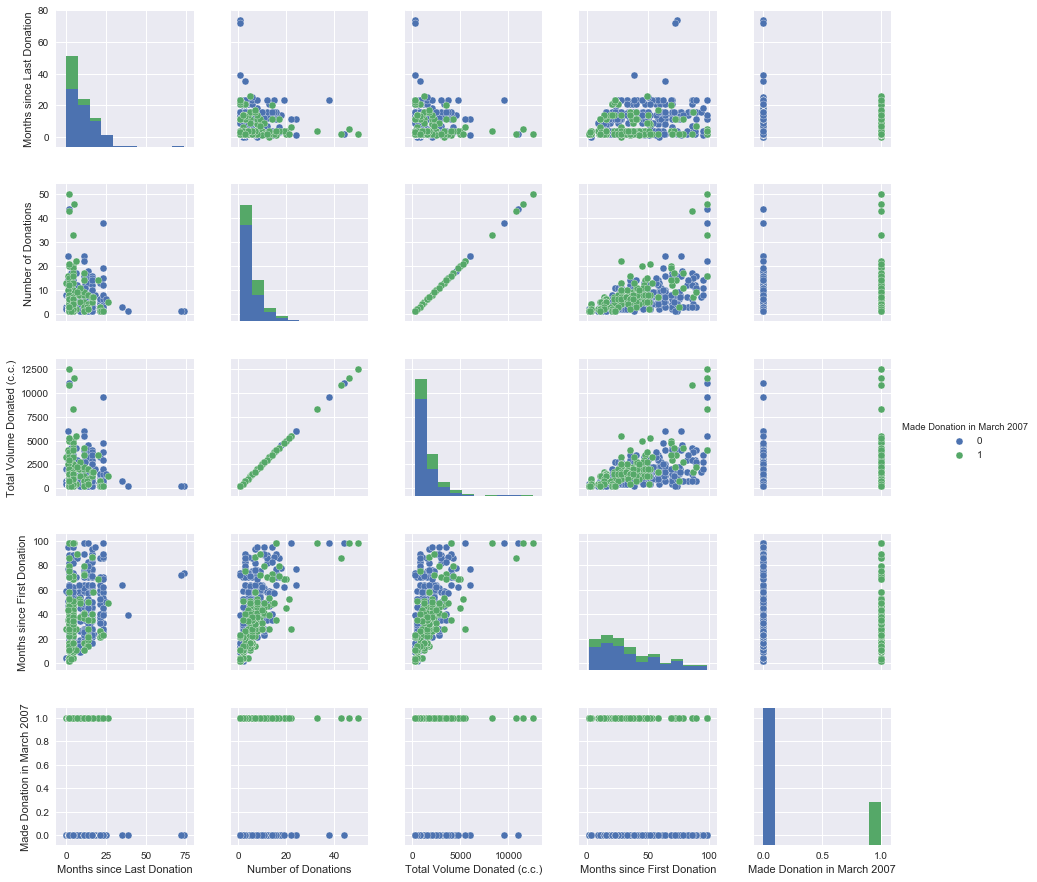

In [50]:
sns.pairplot(df,hue='Made Donation in March 2007')
plt.show()

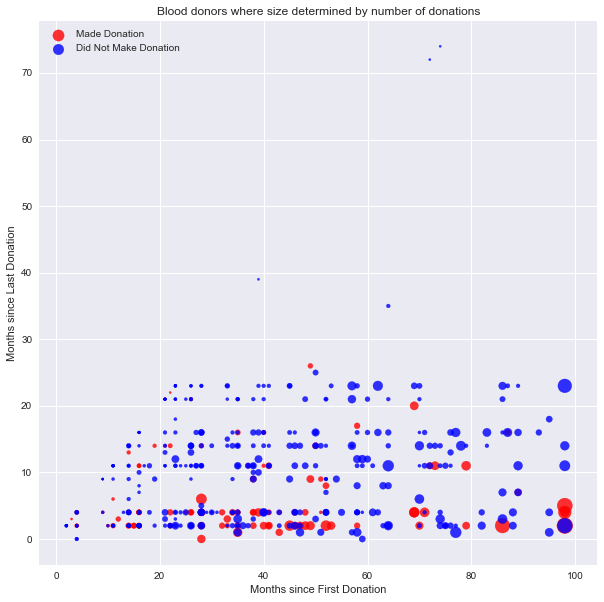

In [51]:
# Dropping Total Volume Donated (c.c.), since it has a direct correlation with 'Number of Donations' and
# 'Number of Donations' may not require scaling.
# Next we make a scatter plot using size to encode the number of donations. THere is a great deal of 
# dependence between the remaining features. Months since first donation and number of donations are clearly
# correlated, as well as months since first donation and months since last donation.
# In particular, months since last donation <= months since first donation.

data=df.drop('Total Volume Donated (c.c.)',axis=1)

plt.figure(figsize=(10,10))

plt.scatter(x = data.loc[data['Made Donation in March 2007']==1,'Months since First Donation'], y = data.loc[data['Made Donation in March 2007']==1,'Months since Last Donation'], s = 5*data.loc[data['Made Donation in March 2007']==1,'Number of Donations'], c = 'red', label='Made Donation', alpha = 0.8)
plt.scatter(x = data.loc[data['Made Donation in March 2007']==0,'Months since First Donation'], y = data.loc[data['Made Donation in March 2007']==0,'Months since Last Donation'], s = 5*data.loc[data['Made Donation in March 2007']==0,'Number of Donations'], c = 'blue', label='Did Not Make Donation', alpha = 0.8)

plt.xlabel('Months since First Donation')
plt.ylabel('Months since Last Donation')
plt.title('Blood donors where size determined by number of donations')
plt.legend(loc='upper left')

plt.show()


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


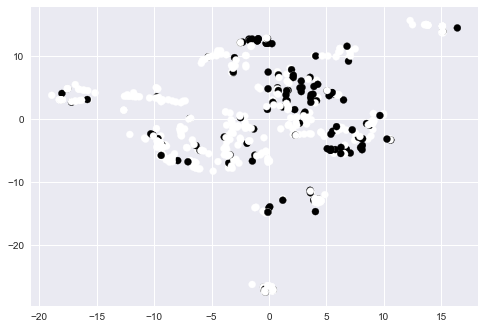

In [52]:
# t-distributed Stochastic Neighborhood Embedding is a technique for projecting higher-dimensional data into
# into 2 or 3 dimensions. The embedding aims to preserve distance and neighborhood relationships by placing
# lacing a t-distribution around the original data points, and calculating probable nieghbors in the lower dimensions.
# In this case, there is no significant grouping or spatial relationship to observe as the classes are spread
# nearly evenly.

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

steps = [('scaler', StandardScaler()),
          ('tsne', TSNE(learning_rate=200))]

pipeline = Pipeline(steps)

tsne_features = pipeline.fit_transform(data.iloc[:,:-1].values)

xs = tsne_features[:,0]
ys = tsne_features[:,1]

plt.scatter(xs,ys,c=data['Made Donation in March 2007'])
plt.show()


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


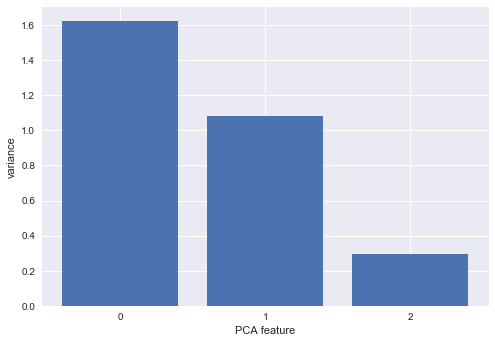

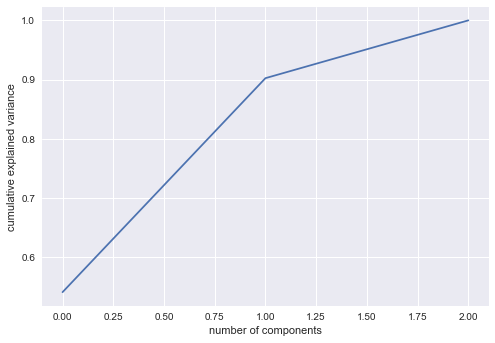

In [53]:
# Principal Components Analysis is applied to inform possible dimensionality reduction, which most likely is not 
# needed given there are only 3 features. The transformation yields two dominant principle components, which together
# explain 90% of the variance in the data.

from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

scaler=StandardScaler()
pca=PCA()

pipeline = make_pipeline(scaler,pca)

pipeline.fit(data.iloc[:,:-1].values)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

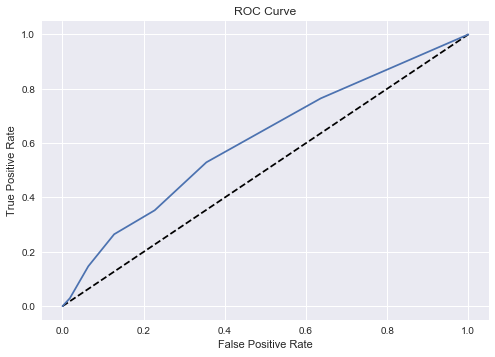

Tuned KNN Parameter: {'n_neighbors': 8}
Tuned KNN Accuracy: -1.8313812306915325
Accuracy: -2.3264729867274965
Log-Loss: 2.3264729867274965
[[103   7]
 [ 29   5]]
             precision    recall  f1-score   support

        0.0       0.78      0.94      0.85       110
        1.0       0.42      0.15      0.22        34

avg / total       0.69      0.75      0.70       144

AUC: 0.607620320855615


In [54]:
# K Nearest Neighbors(KNN) classification. A test-train split is performed using the proportion of classes to balance
# the split. Cross-validation is used to decide the optimal number of neighbors. The ouput shows a series of
# performance metrics ranging from accuracy to area under the ROC curve.
# The resulting confusion matrix shows that the class imbalance is causing
# the classifier to underestimate the number of donations made in March 2007. The target metric to be minimized
# is log-loss, and this implementation of KNN doesn't give a good value of log-loss or any other performance value.

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

data=data.astype(np.float64)
X=data.iloc[:,0:3].values
y=data.iloc[:,3].values

neighbors=np.arange(2,9)
param_grid={'n_neighbors':neighbors}
knn=KNeighborsClassifier()

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)

# Defining a function to score log-loss for cross-validation.
def scoring_model(estimator,X,y):
    z=estimator.predict_proba(X)
    score=log_loss(y, z[:,1])
    return -score

knn_cv=GridSearchCV(knn,param_grid,cv=4,scoring=scoring_model)

knn_cv.fit(X_train,y_train)

y_pred=knn_cv.predict_proba(X_test)
y_predic=knn_cv.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned KNN Parameter: {}".format(knn_cv.best_params_))
print("Tuned KNN Accuracy: {}".format(knn_cv.best_score_))
print("Accuracy: {}".format(knn_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

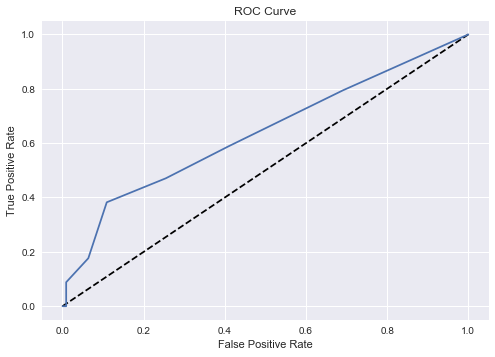

Accuracy: 0.7569444444444444
Log-Loss: 2.08278164973738
[[103   7]
 [ 28   6]]
             precision    recall  f1-score   support

        0.0       0.79      0.94      0.85       110
        1.0       0.46      0.18      0.26        34

avg / total       0.71      0.76      0.71       144

AUC: 0.6358288770053475


In [55]:
# Scaling the features does little to increase the performance of KNN.
# Need to change models.

steps = [('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=8))]

pipeline = Pipeline(steps)

pipeline.fit(X_train,y_train)

y_pred = pipeline.predict_proba(X_test)
y_predic=pipeline.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

#print("Accuracy: {}".format(cv.score(X_test, y_test)))
#print("Tuned KNN Accuracy: {}".format(cv.best_score_))
#print("Tuned Model Parameters: {}".format(cv.best_params_))
print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

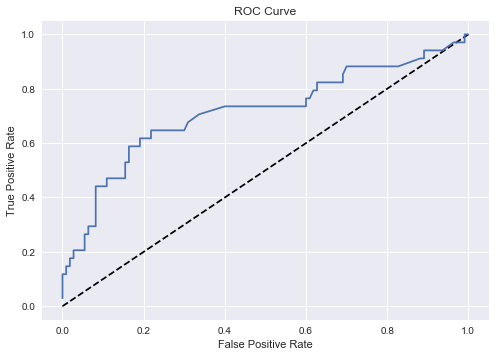

Accuracy: 0.7847222222222222
Log-Loss: 0.5992363127486379
[[106   4]
 [ 27   7]]
             precision    recall  f1-score   support

        0.0       0.80      0.96      0.87       110
        1.0       0.64      0.21      0.31        34

avg / total       0.76      0.78      0.74       144

AUC: 0.7147058823529411


In [56]:
# Naive Bayes classifier using a Gaussian kernal is a significant improvement upon KNN. It has a slightly lower accuracy,
# but it has a significantly better log-loss and AUC score. Accuracy is the least important metric for this type of 
# classfication problem. However, it should be noted that the present classifier continues to underestimate the number
# of donations made in March, but it does not give as high a pobability to these misclassifications.  One solution 
# may be to combine a Naive Bayes classifier with a resampling method that balances the class data.

from sklearn.naive_bayes import GaussianNB

steps = [('scaler', StandardScaler()),
         ('GNB', GaussianNB())]

pipeline = Pipeline(steps)

pipeline.fit(X_train,y_train)

y_predic = pipeline.predict(X_test)
y_pred = pipeline.predict_proba(X_test)
y_nbayes = y_pred

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

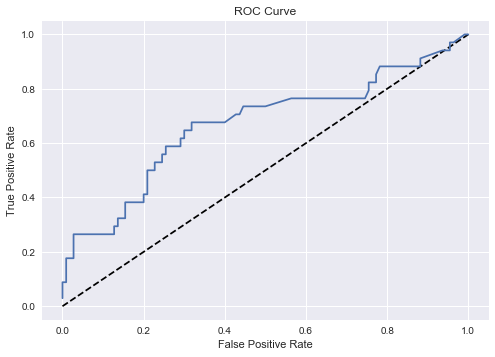

Accuracy: 0.6805555555555556
Log-Loss: 1.3953260638263896
[[77 33]
 [13 21]]
             precision    recall  f1-score   support

        0.0       0.86      0.70      0.77       110
        1.0       0.39      0.62      0.48        34

avg / total       0.75      0.68      0.70       144

AUC: 0.667379679144385


In [57]:
# Naive Bayes classifier with a Multinomial kernel. A multinomial kernel may better represent the disrete data,
# but the performance metrics do not back this up. The Gaussian kernel performed much better, in terms of the
# performance metrics, but the multinomial kernel actually overestimated the number of donations in March.

from sklearn.naive_bayes import MultinomialNB

steps = [('MNB', MultinomialNB())]

pipeline = Pipeline(steps)

pipeline.fit(X_train,y_train)

y_predic = pipeline.predict(X_test)
y_pred = pipeline.predict_proba(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Accuracy: {}".format(pipeline.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

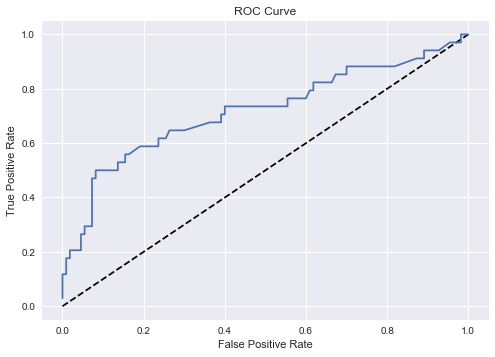

Tuned logreg Parameter: {'logreg__penalty': 'l1', 'logreg__C': 1}
Tuned logreg Accuracy: -0.4911836947356904
Accuracy: -0.4988679240427327
Log-Loss: 0.4988679240427327
[[108   2]
 [ 27   7]]
             precision    recall  f1-score   support

        0.0       0.80      0.98      0.88       110
        1.0       0.78      0.21      0.33        34

avg / total       0.79      0.80      0.75       144

AUC: 0.7179144385026738


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [58]:
# We now turn to classic logistic regression, and as Andrew Ng and Michael I. Jordan pointed out in a 2001 paper,
# logistic regression and naive Bayes classifiers are a discriminant-generative pair when the input data is discrete.
# This is precisely the situation we have here. Their paper showed that the generative model (i.e. naive Bayes)
# usually has a higher asymptotic error as compared to the discriminant model (i.e. logistic regression). However,
# the generative model may do better with a smaller sample size as it converges quicker in general.
# We explore this notion now.
# Logistic regression with L1 regularisation does improve upon Naive Bayes with respect to
# log-loss and AUC. It currently underestimates donations made in March.

from sklearn.linear_model import LogisticRegression

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)
y_logreg=y_pred

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Accuracy: {}".format(logreg_cv.best_score_))
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

test=pd.read_csv('python_files/Competition/blood/test_data.csv',index_col=0)
test=test.drop('Total Volume Donated (c.c.)', axis=1)
y_predict = logreg_cv.predict_proba(test.values)
y_predict_log = logreg_cv.predict_proba(test.values)
y_predict=pd.DataFrame(y_predict[:,1],index=test.index)
y_predict.columns=['Made Donation in March 2007']
y_predict.to_csv('blood_predict.csv')

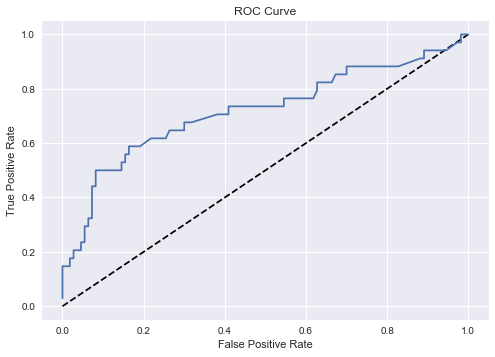

Tuned logreg Parameter: {'logreg__penalty': 'l2', 'logreg__C': 1000}
Tuned logreg Accuracy: -0.6084656911136174
Accuracy: -0.6219803822680416
Log-Loss: 0.6219803822680416
[[65 45]
 [ 9 25]]
             precision    recall  f1-score   support

        0.0       0.88      0.59      0.71       110
        1.0       0.36      0.74      0.48        34

avg / total       0.76      0.62      0.65       144

AUC: 0.7189839572192513


In [59]:
# We now execute logistic regression with class_weight set to 'balanced' with aim of eliminating the underestimation 
# of donations in March. However, as the output indicates it now severly overestimates the occurrence of donations
# made in March. The AUC score increased very slightly, but the log-loss worsened quite a bit.

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(class_weight='balanced'))]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Accuracy: {}".format(logreg_cv.best_score_))
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

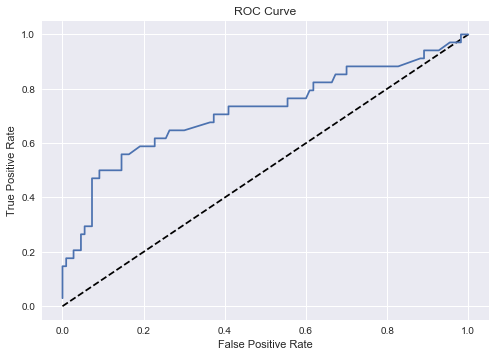

Tuned logreg Parameter: {'logreg__penalty': 'l1', 'logreg__C': 1000}
Tuned logreg Accuracy: -0.5202696963142557
Accuracy: -0.5312970593492855
Log-Loss: 0.5312970593492855
[[98 12]
 [17 17]]
             precision    recall  f1-score   support

        0.0       0.85      0.89      0.87       110
        1.0       0.59      0.50      0.54        34

avg / total       0.79      0.80      0.79       144

AUC: 0.7179144385026737


In [60]:
# Customizing the class_weight to account for the class imbalance does increase the output of the confusion matrix,
# as well as recall, precision, and the f1-score. However, the log-loss is still not quite as good as the unbalanced
# logistic regression.

steps = [('scaler', StandardScaler()),
         ('logreg', LogisticRegression(class_weight={0:.36,1:.64}))]

pipeline = Pipeline(steps)


param_grid = { 'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Accuracy: {}".format(logreg_cv.best_score_))
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

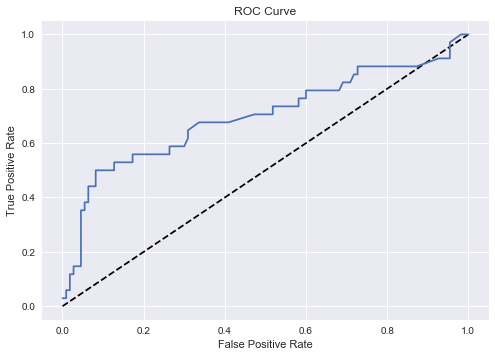

Tuned logreg Parameter: {'logreg__penalty': 'l1', 'logreg__C': 1, 'poly__interaction_only': 'True', 'poly__degree': 2}
Tuned logreg Accuracy: -0.4722675280931274
Accuracy: -0.5155154612716536
Log-Loss: 0.5155154612716536
[[105   5]
 [ 27   7]]
             precision    recall  f1-score   support

        0.0       0.80      0.95      0.87       110
        1.0       0.58      0.21      0.30        34

avg / total       0.75      0.78      0.73       144

AUC: 0.6975935828877005


In [61]:
from sklearn.preprocessing import PolynomialFeatures

steps = [('poly', PolynomialFeatures()),
         ('scaler', StandardScaler()),
         ('logreg', LogisticRegression())]

pipeline = Pipeline(steps)


param_grid = {'poly__degree':[1,2,3],
              'poly__interaction_only':['True','False'],
              'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
              "logreg__penalty": ['l1','l2']}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Accuracy: {}".format(logreg_cv.best_score_))
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))


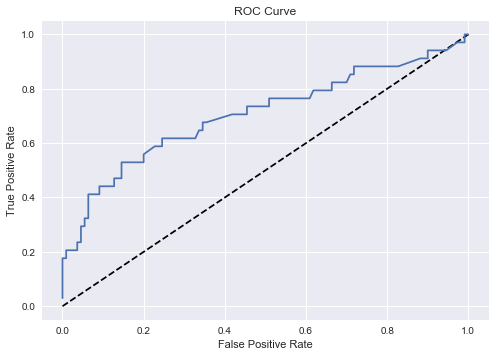

Tuned logreg Parameter: {'pca__n_components': 2}
Tuned logreg Accuracy: -0.48906557298934356
Accuracy: -0.5108928063365896
Log-Loss: 0.5108928063365896
[[109   1]
 [ 28   6]]
             precision    recall  f1-score   support

        0.0       0.80      0.99      0.88       110
        1.0       0.86      0.18      0.29        34

avg / total       0.81      0.80      0.74       144

AUC: 0.7064171122994652


In [62]:
# Principal Components Analysis transforms the feature matrix via SVD or equivalently an eigendecomposition
# of the standardized covariance matrix. The eigenvectors of the covariance matrix are the transformed features,
# and the magnitude of the associated eigenvalue corresponds to the amount of variance in the data that
# is explained by the transformed feature. Selecting the highest eignevalues allows for a form of
# dimension reduction. Here we pair PCA with Logistic Regression and examine the performance. It is comparable to the
# performance of Logistic Regression without PCA, so it is an unnecessary computation, in this case.

steps = [('scaler', StandardScaler()),
         ('pca', PCA()),
         ('logreg', LogisticRegression(C=1,penalty='l1'))]

pipeline = Pipeline(steps)


param_grid = {'pca__n_components': [1,2,3]}

logreg_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

logreg_cv.fit(X_train,y_train)

y_predic = logreg_cv.predict(X_test)
y_pred = logreg_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned logreg Parameter: {}".format(logreg_cv.best_params_))
print("Tuned logreg Accuracy: {}".format(logreg_cv.best_score_))
print("Accuracy: {}".format(logreg_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

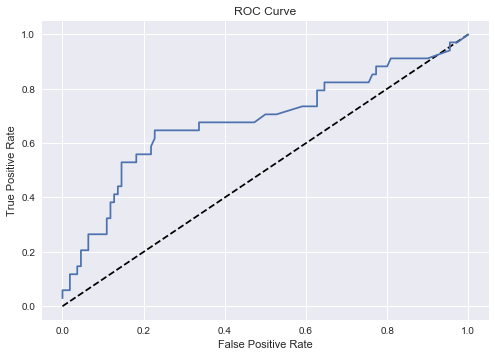

Tuned RFC Parameter: {'RFC__max_depth': 4, 'RFC__n_estimators': 1200}
Tuned RFC Accuracy: -0.4787178718039872
Accuracy: -0.5269848909094237
Log-Loss: 0.5269848909094237
[[103   7]
 [ 26   8]]
             precision    recall  f1-score   support

        0.0       0.80      0.94      0.86       110
        1.0       0.53      0.24      0.33        34

avg / total       0.74      0.77      0.74       144

AUC: 0.6828877005347594


In [63]:
# A random forest classifier is trained and fit using cross-validation based on the number of trees and
# the max depth of the tree.

from sklearn.ensemble import RandomForestClassifier

steps = [('scaler', StandardScaler()),
         ('RFC', RandomForestClassifier(random_state=21))]

pipeline = Pipeline(steps)

param_grid = { "RFC__n_estimators": np.arange(200,2000,200),"RFC__max_depth":np.arange(2,8)}

RFC_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

RFC_cv.fit(X_train,y_train)

y_predic = RFC_cv.predict(X_test)
y_pred = RFC_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned RFC Parameter: {}".format(RFC_cv.best_params_))
print("Tuned RFC Accuracy: {}".format(RFC_cv.best_score_))
print("Accuracy: {}".format(RFC_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

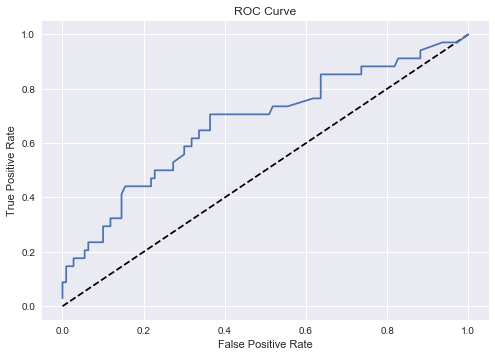

Tuned RFC Parameter: {'RFC__max_depth': 7, 'RFC__n_estimators': 1200}
Tuned RFC Accuracy: -0.5264026853571102
Accuracy: -0.5991043625649084
Log-Loss: 0.5991043625649084
[[93 17]
 [19 15]]
             precision    recall  f1-score   support

        0.0       0.83      0.85      0.84       110
        1.0       0.47      0.44      0.45        34

avg / total       0.74      0.75      0.75       144

AUC: 0.6735294117647059


In [64]:
# Random Forests are applied with class balancing, but this did not help the performance of the model. 
# The model still underperforms in comparison to logisitc regression.

steps = [('scaler', StandardScaler()),
         ('RFC', RandomForestClassifier(random_state=21,class_weight='balanced'))]

pipeline = Pipeline(steps)

param_grid = { "RFC__n_estimators": np.arange(200,2000,200),"RFC__max_depth":np.arange(2,8)}

RFC_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

RFC_cv.fit(X_train,y_train)

y_predic = RFC_cv.predict(X_test)
y_pred = RFC_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned RFC Parameter: {}".format(RFC_cv.best_params_))
print("Tuned RFC Accuracy: {}".format(RFC_cv.best_score_))
print("Accuracy: {}".format(RFC_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

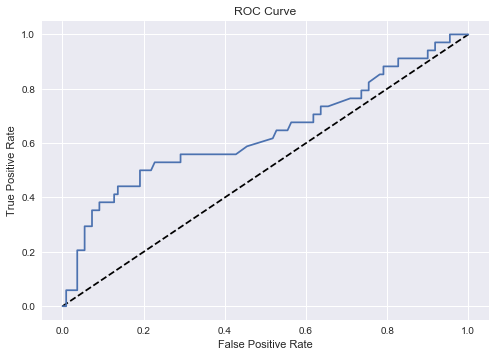

Tuned SVM Parameter: {'SVM__C': 2, 'SVM__gamma': 0.45000000000000007}
Tuned SVM Accuracy: -0.4860474269030292
Accuracy: -0.5116879709013785
Log-Loss: 0.5116879709013785
[[105   5]
 [ 27   7]]
             precision    recall  f1-score   support

        0.0       0.80      0.95      0.87       110
        1.0       0.58      0.21      0.30        34

avg / total       0.75      0.78      0.73       144

AUC: 0.6366310160427807


In [65]:
# A Support Vector Machine is applied, and the performance is near that of logistic regression, but logistic regression
# currently has the edge. More tuning and class balancing may help SVM. It should be noted that log-loss is not a 
# natural metric for SVM, since it doesn't directly output class probabilities. Instead, a sigmoid function is used,
# which is a rough approximation in some cases, so SVM may not be optimal for this task, despite it's
# otherwise stellar classfication capabilities.

from sklearn.svm import SVC

steps = [('scaler', StandardScaler()),
         ('SVM', SVC(probability=True))]

pipeline = Pipeline(steps)

param_grid = {'SVM__C':np.arange(1,16),
              'SVM__gamma':np.linspace(0.1,0.8,9)}

SVM_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

SVM_cv.fit(X_train,y_train)

y_predic = SVM_cv.predict(X_test)
y_pred = SVM_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned SVM Parameter: {}".format(SVM_cv.best_params_))
print("Tuned SVM Accuracy: {}".format(SVM_cv.best_score_))
print("Accuracy: {}".format(SVM_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

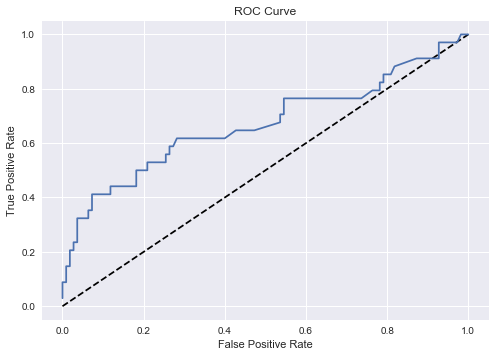

Tuned SVM Parameter: {'SVM__C': 3, 'SVM__gamma': 0.25}
Tuned SVM Accuracy: -0.48011242956000927
Accuracy: -0.49570333814862383
Log-Loss: 0.49570333814862383
[[83 27]
 [16 18]]
             precision    recall  f1-score   support

        0.0       0.84      0.75      0.79       110
        1.0       0.40      0.53      0.46        34

avg / total       0.73      0.70      0.71       144

AUC: 0.6692513368983957


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [66]:
# Penalized SVM (to deal with imbalanced classes). Class balancing does help SVM, but it is still a little behind
# the performance of logisitic regression.

steps = [('scaler', StandardScaler()),
         ('SVM', SVC(class_weight='balanced', probability=True,random_state=21))]

pipeline = Pipeline(steps)

param_grid = {'SVM__C':np.arange(1,20,1),
              'SVM__gamma':np.linspace(0.05,0.25,5)}

SVM_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

SVM_cv.fit(X_train,y_train)

y_predic = SVM_cv.predict(X_test)
y_pred = SVM_cv.predict_proba(X_test)
y_svm=y_pred

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned SVM Parameter: {}".format(SVM_cv.best_params_))
print("Tuned SVM Accuracy: {}".format(SVM_cv.best_score_))
print("Accuracy: {}".format(SVM_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

y_predict = SVM_cv.predict_proba(test.values)
y_predict=0.6*y_predict+0.4*y_predict_log
y_predict=pd.DataFrame(y_predict[:,1],index=test.index)
y_predict.columns=['Made Donation in March 2007']
y_predict.to_csv('blood_predict.csv')

In [67]:
# We now examine a weighted combination of predictions from the above SVM model and the logistic regression model.
# The logistic regression model underestimated the occurence of donations in March, while the SVM model overestimated
# the probability of making a donation in March. A combintion of the two yields a superior model.

up=np.linspace(0,1,11)

for i in range(11):
    y_pred=up[i]*y_svm+(1-up[i])*y_logreg
    print(up[i])
    print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
    print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

0.0
Log-Loss: 0.4988679240427327
AUC: 0.7179144385026738
0.1
Log-Loss: 0.4936736141747574
AUC: 0.7203208556149733
0.2
Log-Loss: 0.48977921224566817
AUC: 0.7216577540106952
0.3
Log-Loss: 0.48695636441465634
AUC: 0.7197860962566845
0.4
Log-Loss: 0.48508693197820446
AUC: 0.718716577540107
0.5
Log-Loss: 0.4841202590177312
AUC: 0.7181818181818183
0.6
Log-Loss: 0.48405843025094775
AUC: 0.7147058823529412
0.7
Log-Loss: 0.4849582164369909
AUC: 0.7074866310160428
0.8
Log-Loss: 0.48695271891035474
AUC: 0.7072192513368983
0.9
Log-Loss: 0.490317719725408
AUC: 0.6919786096256684
1.0
Log-Loss: 0.49570333814862383
AUC: 0.6692513368983957


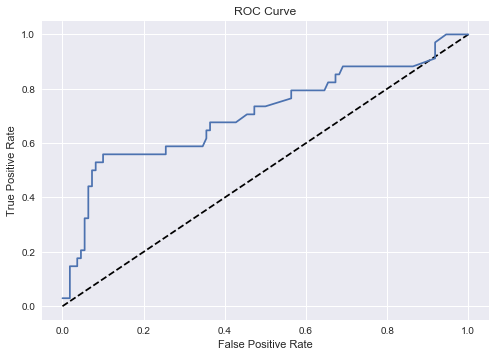

Tuned SVM Parameter: {'SVM__C': 12, 'SVM__gamma': 0.02}
Tuned SVM Accuracy: -0.47643769311625667
Accuracy: -0.48731840106634305
Log-Loss: 0.48731840106634305
[[104   6]
 [ 25   9]]
             precision    recall  f1-score   support

        0.0       0.81      0.95      0.87       110
        1.0       0.60      0.26      0.37        34

avg / total       0.76      0.78      0.75       144

AUC: 0.7072192513368983


/usr/local/lib/python3.4/dist-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


In [68]:
# Customizing the class balance yields the best performance yet, but it just barely surpasses logistic regression.
# Depending on desired implementations of this model the computational efficiency of logistic regression may
# still make that the more desirable model.

steps = [('scaler', StandardScaler()),
         ('SVM', SVC(class_weight={0:.4,1:.6}, probability=True, random_state=21))]

pipeline = Pipeline(steps)

param_grid = {'SVM__C':np.arange(1,20,1),
              'SVM__gamma':np.linspace(0.01,0.25,25)}

SVM_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

SVM_cv.fit(X_train,y_train)

y_predic = SVM_cv.predict(X_test)
y_pred = SVM_cv.predict_proba(X_test)
y_svmw=y_pred

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned SVM Parameter: {}".format(SVM_cv.best_params_))
print("Tuned SVM Accuracy: {}".format(SVM_cv.best_score_))
print("Accuracy: {}".format(SVM_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

y_predict = SVM_cv.predict_proba(test.values)
y_predict=pd.DataFrame(y_predict[:,1],index=test.index)
y_predict.columns=['Made Donation in March 2007']
y_predict.to_csv('blood_predict.csv')

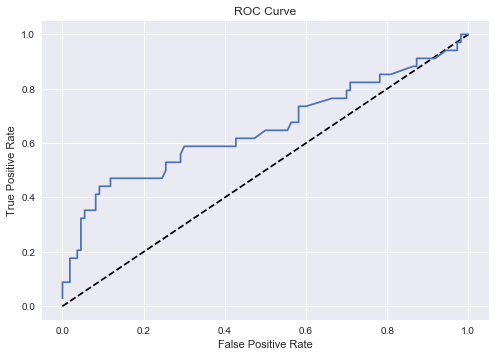

Tuned SVM Parameter: {'SVM__C': 18, 'SVM__degree': 3, 'SVM__gamma': 0.20000000000000001}
Tuned SVM Accuracy: -0.5357952356828224
Accuracy: -0.5325109014351251
Log-Loss: 0.532510901435125
[[108   2]
 [ 31   3]]
             precision    recall  f1-score   support

        0.0       0.78      0.98      0.87       110
        1.0       0.60      0.09      0.15        34

avg / total       0.74      0.77      0.70       144

AUC: 0.6516042780748662


In [69]:
# SVM with a polynomial kernel, instead of the default kernal consisting of radial basis functions (RBF). The RBF
# kernel gives better performance.

steps = [('scaler', StandardScaler()),
         ('SVM', SVC(class_weight={0:0.4,1:0.6}, kernel='poly',probability=True))]

pipeline = Pipeline(steps)

param_grid = {'SVM__C':np.arange(1,20,1), 'SVM__degree':[2,3,4],
              'SVM__gamma':np.linspace(0.05,0.25,5)}

SVM_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

SVM_cv.fit(X_train,y_train)

y_predic = SVM_cv.predict(X_test)
y_pred = SVM_cv.predict_proba(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned SVM Parameter: {}".format(SVM_cv.best_params_))
print("Tuned SVM Accuracy: {}".format(SVM_cv.best_score_))
print("Accuracy: {}".format(SVM_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred)))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

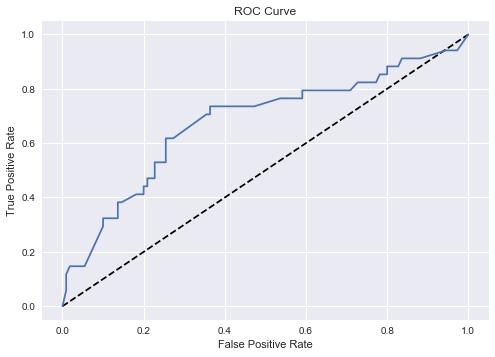

Tuned BLR Parameter: {'BLR__n_estimators': 20}
Tuned BLR Accuracy: -0.47680230597452455
Accuracy: -0.521489572495538
Log-Loss: 0.521489572495538
[[99 11]
 [23 11]]
             precision    recall  f1-score   support

        0.0       0.81      0.90      0.85       110
        1.0       0.50      0.32      0.39        34

avg / total       0.74      0.76      0.74       144

AUC: 0.6763368983957219


In [70]:
# Boosting relies upon a sequence of weak learning models, usually trees, that subsequently modify to perform
# better on data that was poorly classified. It does have a reasonable log-loss score, but a mediocre AUC.

from sklearn.ensemble import GradientBoostingClassifier

steps = [('scaler', StandardScaler()),
         ('BLR', GradientBoostingClassifier())]

pipeline = Pipeline(steps)

param_grid = { 'BLR__n_estimators' : np.arange(20,500,20)}

BLR_cv = GridSearchCV(pipeline,param_grid,scoring=scoring_model)

BLR_cv.fit(X_train,y_train)

y_predic = BLR_cv.predict(X_test)
y_pred = BLR_cv.predict_proba(X_test)
y_BLR=y_pred

fpr, tpr, thresholds = roc_curve(y_test, y_pred[:,1])
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print("Tuned BLR Parameter: {}".format(BLR_cv.best_params_))
print("Tuned BLR Accuracy: {}".format(BLR_cv.best_score_))
print("Accuracy: {}".format(BLR_cv.score(X_test, y_test)))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))

In [71]:
# SMOTE generates 'synthetic' copies of the underrepresented class, in attempt to balance the data.
# Combining SMOTE with Random Forests does not yield a successful model.

from imblearn.over_sampling import SMOTE

steps = [('scaler', StandardScaler()),
          ('RFC', RandomForestClassifier(random_state=21,n_estimators=500))]

pipeline = Pipeline(steps)

sm=SMOTE(random_state=12,ratio=1.0)

X_train_res,y_train_res = sm.fit_sample(X_train,y_train)
        
pipeline.fit(X_train,y_train)
        
y_pred = pipeline.predict_proba(X_test)
y_predic = pipeline.predict(X_test)
        
print('C = '+str(3)+' and Gamma = '+str(0.275))
print("Log-Loss: {}".format(log_loss(y_test, y_pred[:,1])))
print("AUC: {}".format(roc_auc_score(y_test, y_pred[:,1])))
print(confusion_matrix(y_test, y_predic))
print(classification_report(y_test, y_predic))

C = 3 and Gamma = 0.275
Log-Loss: 1.0153585959281908
AUC: 0.6775401069518718
[[95 15]
 [23 11]]
             precision    recall  f1-score   support

        0.0       0.81      0.86      0.83       110
        1.0       0.42      0.32      0.37        34

avg / total       0.71      0.74      0.72       144



Using TensorFlow backend.


Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 1.0032 - acc: 0.7047 - val_loss: 0.5010 - val_acc: 0.8150
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.6710 - acc: 0.7072 - val_loss: 0.5057 - val_acc: 0.8266
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.5230 - acc: 0.7543 - val_loss: 0.5628 - val_acc: 0.7110
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.5989 - acc: 0.7270 - val_loss: 0.4606 - val_acc: 0.8497
Epoch 5/30
403/403 [==============================] - 0s - loss: 0.5605 - acc: 0.7395 - val_loss: 0.6997 - val_acc: 0.8150
Epoch 6/30
403/403 [==============================] - 0s - loss: 0.5665 - acc: 0.7246 - val_loss: 0.7070 - val_acc: 0.5607
Epoch 7/30
403/403 [==============================] - 0s - loss: 0.5202 - acc: 0.7419 - val_loss: 0.5719 - val_acc: 0.8150


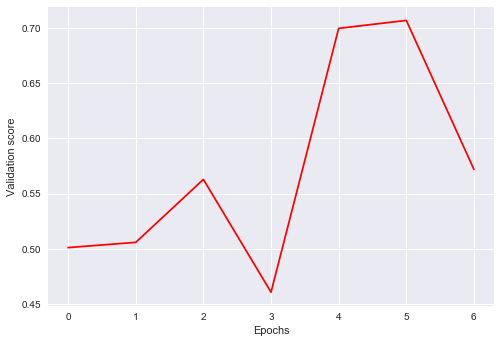

In [72]:
# A neural network using Keras and TensorFlow. THe network consist of two layers with 20 nodes each and the 
# rectifier activation function. The output layer consists of a sigmoid function is used to produce the 
# class probability. THe performance is average, and the network will require more tuning to see if it can 
# approach the performance of logistic regression and SVM for this classification problem.

import numpy as np
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.callbacks import EarlyStopping

n_cols = X.shape[1]

model = Sequential()

model.add(Dense(20, activation='relu', input_shape=(n_cols,)))
model.add(Dense(20, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='sgd', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

early_stopping_monitor = EarlyStopping(patience=2)

class_weight={0:1., 1:3}

model_fit=model.fit(X,y,validation_split=0.3,epochs=30,callbacks=[early_stopping_monitor])

plt.plot(model_fit.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

In [73]:
# The following function is simpy for ease of tuning by trial and error.

def create_model(num_layers=0,activation=['relu'],num_nodes=[1],class_weight={0:1, 1:3},optimizer='sgd',predict=False):
    model = Sequential()
    model.add(Dense(num_nodes[0], activation=activation[0],input_shape=(n_cols,)))
    for i in range(num_layers):
        model.add(Dense(num_nodes[i+1],activation=activation[i+1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                 loss='binary_crossentropy',
                 metrics=['accuracy'])
    early_stopping_monitor=EarlyStopping(patience=2)
    class_weight=class_weight
    model_fit=model.fit(X,y,validation_split=0.3,epochs=30,callbacks=[early_stopping_monitor])
    plt.plot(model_fit.history['val_loss'], 'r')
    plt.xlabel('Epochs')
    plt.ylabel('Validation score')
    plt.show()
    if predict:
        predictions = model.predict(test.values)
        y_predict=pd.DataFrame(predictions,index=test.index)
        y_predict.columns=['Made Donation in March 2007']
        y_predict.to_csv('blood_predict.csv')

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 0.7936 - acc: 0.2978 - val_loss: 0.7105 - val_acc: 0.4451
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.6574 - acc: 0.6328 - val_loss: 0.5783 - val_acc: 0.7341
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.6135 - acc: 0.7270 - val_loss: 0.5533 - val_acc: 0.8150
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.6023 - acc: 0.7370 - val_loss: 0.5396 - val_acc: 0.8150
Epoch 5/30
403/403 [==============================] - 0s - loss: 0.5959 - acc: 0.7370 - val_loss: 0.5299 - val_acc: 0.8150
Epoch 6/30
403/403 [==============================] - 0s - loss: 0.5919 - acc: 0.7370 - val_loss: 0.5231 - val_acc: 0.8150
Epoch 7/30
403/403 [==============================] - 0s - loss: 0.5893 - acc: 0.7370 - val_loss: 0.5180 - val_acc: 0.8150
Epoch 8/30
403/403 [==============================] - 0s - loss: 0.5873 - acc: 0.7370 - val_l

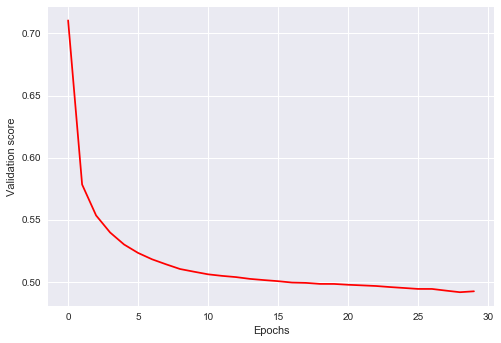

In [74]:
num_layers=1
activation=['relu','sigmoid']
num_nodes=[10,10]
create_model(num_layers,activation,num_nodes)

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 0.7144 - acc: 0.6551 - val_loss: 0.4818 - val_acc: 0.8439
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.5614 - acc: 0.7345 - val_loss: 0.5427 - val_acc: 0.8150
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.5722 - acc: 0.7295 - val_loss: 0.5354 - val_acc: 0.7514
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.5477 - acc: 0.7395 - val_loss: 0.4980 - val_acc: 0.8150


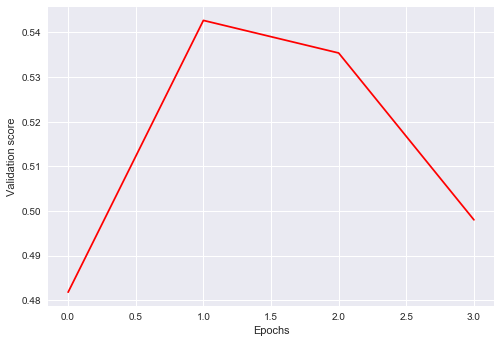

In [75]:
num_layers=1
activation=['relu','relu']
num_nodes=[10,10]
create_model(num_layers,activation,num_nodes)

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 1.1554 - acc: 0.5831 - val_loss: 0.4420 - val_acc: 0.8150
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.5190 - acc: 0.7543 - val_loss: 0.4502 - val_acc: 0.8439
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.5287 - acc: 0.7469 - val_loss: 0.4520 - val_acc: 0.8150
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.5159 - acc: 0.7444 - val_loss: 0.4650 - val_acc: 0.8150


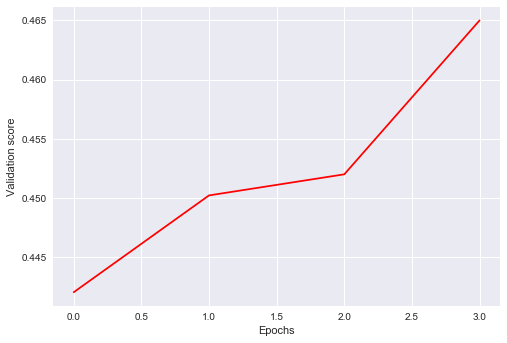

In [76]:
num_layers=1
activation=['relu','relu']
num_nodes=[20,20]
create_model(num_layers,activation,num_nodes)

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 1.2326 - acc: 0.6179 - val_loss: 0.4993 - val_acc: 0.8150
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.7396 - acc: 0.7246 - val_loss: 0.6049 - val_acc: 0.8150
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.6175 - acc: 0.7097 - val_loss: 0.6733 - val_acc: 0.8150
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.6569 - acc: 0.7171 - val_loss: 0.5208 - val_acc: 0.8150


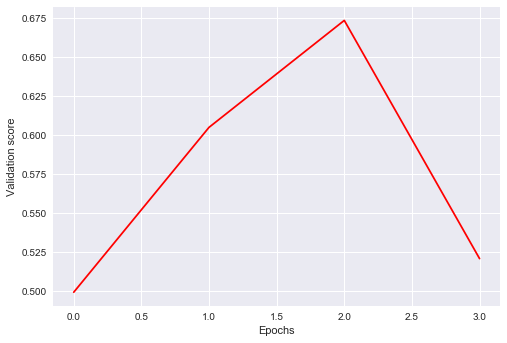

In [77]:
num_layers=1
activation=['relu','relu']
num_nodes=[20,20]
create_model(num_layers,activation,num_nodes)

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 2.2743 - acc: 0.2779 - val_loss: 0.9113 - val_acc: 0.5318
Epoch 2/30
403/403 [==============================] - 0s - loss: 0.6537 - acc: 0.6898 - val_loss: 0.4520 - val_acc: 0.8150
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.5865 - acc: 0.7469 - val_loss: 0.4966 - val_acc: 0.8150
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.5813 - acc: 0.7419 - val_loss: 0.4548 - val_acc: 0.8150
Epoch 5/30
403/403 [==============================] - 0s - loss: 0.5457 - acc: 0.7667 - val_loss: 0.4337 - val_acc: 0.8266
Epoch 6/30
403/403 [==============================] - 0s - loss: 0.5356 - acc: 0.7667 - val_loss: 0.4358 - val_acc: 0.8266
Epoch 7/30
403/403 [==============================] - 0s - loss: 0.5291 - acc: 0.7593 - val_loss: 0.4391 - val_acc: 0.8208
Epoch 8/30
403/403 [==============================] - 0s - loss: 0.5325 - acc: 0.7419 - val_l

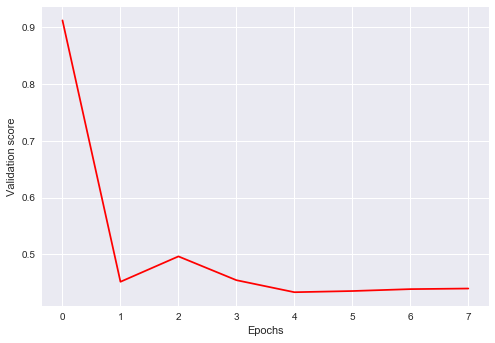

In [78]:
num_layers=1
activation=['relu','relu']
num_nodes=[20,20]
create_model(num_layers,activation,num_nodes,optimizer='adam',predict=True)

Train on 403 samples, validate on 173 samples
Epoch 1/30
403/403 [==============================] - 0s - loss: 2.3365 - acc: 0.2630 - val_loss: 2.0327 - val_acc: 0.1850
Epoch 2/30
403/403 [==============================] - 0s - loss: 1.5377 - acc: 0.2630 - val_loss: 1.1915 - val_acc: 0.2197
Epoch 3/30
403/403 [==============================] - 0s - loss: 0.8706 - acc: 0.3846 - val_loss: 0.6468 - val_acc: 0.6590
Epoch 4/30
403/403 [==============================] - 0s - loss: 0.6060 - acc: 0.7196 - val_loss: 0.5005 - val_acc: 0.8150
Epoch 5/30
403/403 [==============================] - 0s - loss: 0.5644 - acc: 0.7419 - val_loss: 0.4789 - val_acc: 0.8150
Epoch 6/30
403/403 [==============================] - 0s - loss: 0.5336 - acc: 0.7494 - val_loss: 0.4572 - val_acc: 0.8150
Epoch 7/30
403/403 [==============================] - 0s - loss: 0.5174 - acc: 0.7494 - val_loss: 0.4471 - val_acc: 0.8150
Epoch 8/30
403/403 [==============================] - 0s - loss: 0.5135 - acc: 0.7568 - val_l

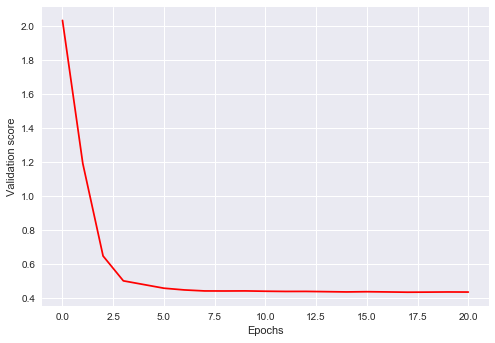

In [80]:
# Rectifier activation functions and the Adam optimization are working the best. This neural network performance
# performance surpasses both the SVM model and the logistic regression model. However, the incremental gain in 
# in performance is not very large, and I suspect some overfitting may be occuring. This was the final prediction 
# turned into the competition, and with it I placed 82nd out of 3019 competitors, yet very similar versions of this 
# model did not score as well on the competition test set. I have a feeling either the SVM or the logistic regression
# will do a better job on other unseen data.

num_layers=1
activation=['relu','relu','relu']
num_nodes=[10,10,10]
create_model(num_layers,activation,num_nodes,optimizer='adam',predict=True)